# 文本分类

通过现有的语料。然后，训练一个模型来对这些评论进行分类，分为正面的评论和负面的评论。

然后设计了一个简单的前馈网络，利用词袋模型获得每一个评论的向量表示，并输入进前馈网络得到很好的分类效果，同时还对这个网络进行了简单的剖析。

然后，尝试了两种RNN网络，一种是普通的RNN，另一种是LSTM，对现有的神经网络来进行一个优化。本程序展示了它们在处理同样的文本分类问题上的用法


In [4]:
# 导入程序所需要的程序包


#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
#from torch.autograd import Variable

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 一、数据处理

数据来源于京东上的商品评论，在当前文件夹下面的语料，good_txt与bad_txt,每一条评论都会配合有一个评分。我们通过调用接口将相应的参数传入进去就可以得到评论。

根据评分的高低，可以划分成正向和负向两组标签

### 1.数据预处理

In [5]:
# 数据来源文件
good_file = 'good.txt'
bad_file  = 'bad.txt'

# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)  
    return(sentence)

#扫描所有的文本，分词、建立词典，分出正向还是负向的评论，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(good_file, bad_file, is_filter = True):
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储正向的评论
    neg_sentences = [] #存储负向的评论
    with open(good_file, 'r',encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
            #分词
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r',encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，diction的每一项为{w:[id, 单词出现次数]}
    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))
    return(pos_sentences, neg_sentences, diction)

#根据单词返还单词的编码
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

#根据编码获得单词
def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)

pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, True)
st = sorted([(v[1], w) for w, v in diction.items()])
st


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86134\AppData\Local\Temp\jieba.cache
Loading model cost 0.632 seconds.
Prefix dict has been built successfully.


good.txt 包含 8089 行, 100839 个词.
bad.txt 包含 5076 行, 56070 个词.
字典大小：7135


[(1, '---'),
 (1, '------'),
 (1, '000000000'),
 (1, '0000000000000000'),
 (1, '00000000000000000'),
 (1, '0000000000000000000000'),
 (1, '000000000000000000000000000'),
 (1, '00000000000000000000000000000000000000000000000'),
 (1, '1006'),
 (1, '111'),
 (1, '1111111'),
 (1, '11111111111'),
 (1, '11111111111111'),
 (1, '111111111111111111111111'),
 (1, '11111111111111111111111111111'),
 (1, '111111111111111111111111111111111'),
 (1, '1111111111111111111111111111111111111111111'),
 (1, '115'),
 (1, '122'),
 (1, '12315'),
 (1, '123456'),
 (1, '1255888'),
 (1, '128'),
 (1, '130'),
 (1, '136'),
 (1, '138'),
 (1, '15548'),
 (1, '158105'),
 (1, '160'),
 (1, '16067cm'),
 (1, '165140'),
 (1, '165cm'),
 (1, '166cm68kgxl'),
 (1, '16860'),
 (1, '170CM55'),
 (1, '170M'),
 (1, '170cm75kg'),
 (1, '171819202122'),
 (1, '172'),
 (1, '172153'),
 (1, '175cm'),
 (1, '1805'),
 (1, '180xxl'),
 (1, '183'),
 (1, '185'),
 (1, '1852XL'),
 (1, '185XXL'),
 (1, '185mm'),
 (1, '200000000'),
 (1, '20161218'),
 (1, 

## 二、词袋模型

词袋模型实际上是一种对文本进行向量化的手段，通过统计出词表上的每个单词出现频率，从而将一篇文章向量化

### 1. 训练数据准备

In [6]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l] += 1
    return(1.0 * vector / len(sentence))

# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# 处理正向评论
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(0) #正标签为0
    sentences.append(sentence)

# 处理负向评论
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)

#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(dataset))

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

### 2. 模型定义

In [7]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(dim=1),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

### 3. 训练模型

In [8]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

#循环10个Epoch
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = torch.tensor(np.array([y]), dtype = torch.long)
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

第0轮，训练损失：0.67, 校验损失：0.68, 校验准确率: 0.61
第0轮，训练损失：0.36, 校验损失：0.34, 校验准确率: 0.90
第0轮，训练损失：0.32, 校验损失：0.35, 校验准确率: 0.90
第0轮，训练损失：0.31, 校验损失：0.32, 校验准确率: 0.90
第1轮，训练损失：0.30, 校验损失：0.33, 校验准确率: 0.90
第1轮，训练损失：0.29, 校验损失：0.32, 校验准确率: 0.91
第1轮，训练损失：0.27, 校验损失：0.35, 校验准确率: 0.90
第1轮，训练损失：0.27, 校验损失：0.33, 校验准确率: 0.90
第2轮，训练损失：0.27, 校验损失：0.34, 校验准确率: 0.90
第2轮，训练损失：0.26, 校验损失：0.33, 校验准确率: 0.91
第2轮，训练损失：0.25, 校验损失：0.36, 校验准确率: 0.89
第2轮，训练损失：0.25, 校验损失：0.33, 校验准确率: 0.90
第3轮，训练损失：0.25, 校验损失：0.35, 校验准确率: 0.91
第3轮，训练损失：0.24, 校验损失：0.34, 校验准确率: 0.90
第3轮，训练损失：0.24, 校验损失：0.37, 校验准确率: 0.89
第3轮，训练损失：0.24, 校验损失：0.35, 校验准确率: 0.90
第4轮，训练损失：0.23, 校验损失：0.36, 校验准确率: 0.90
第4轮，训练损失：0.23, 校验损失：0.37, 校验准确率: 0.90
第4轮，训练损失：0.23, 校验损失：0.38, 校验准确率: 0.89
第4轮，训练损失：0.23, 校验损失：0.36, 校验准确率: 0.90
第5轮，训练损失：0.22, 校验损失：0.38, 校验准确率: 0.90
第5轮，训练损失：0.22, 校验损失：0.37, 校验准确率: 0.90
第5轮，训练损失：0.22, 校验损失：0.39, 校验准确率: 0.89
第5轮，训练损失：0.22, 校验损失：0.37, 校验准确率: 0.90
第6轮，训练损失：0.22, 校验损失：0.39, 校验准确率: 0.90
第6轮，训练损失：0.21, 校验损失：0.39, 校验准确率: 0.90
第6轮，训练损失：0.2

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

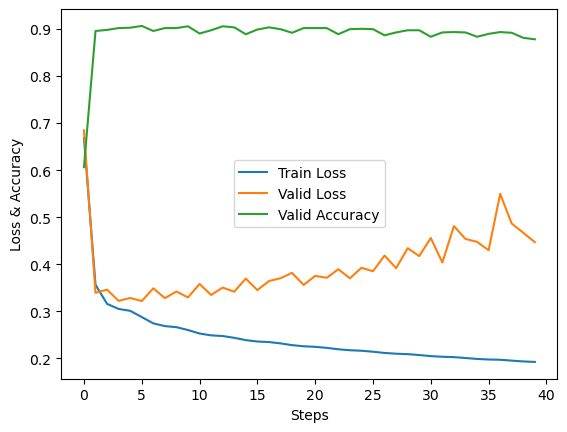

In [10]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [ ]:
# 保存、提取模型（为展示用）
#torch.save(model,'bow.mdl')
#model = torch.load('bow.mdl')

In [11]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = torch.tensor(data, dtype = torch.float).view(1,-1), torch.tensor(np.array([target]), dtype = torch.long)
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

0.9056024558710668

### 4. 解剖神经网络

接下来，我们对训练好的神经网络进行解剖分析。

我们看一看每一个神经元都在检测什么模式；

我们也希望看到神经网络在测试集上判断错误的数据上出错的原因

#### 1). 查看每一层的模式

In [12]:
# 将神经网络的架构打印出来，方便后面的访问
model.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Linear(in_features=7135, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)>

Text(0, 0.5, 'Weights')

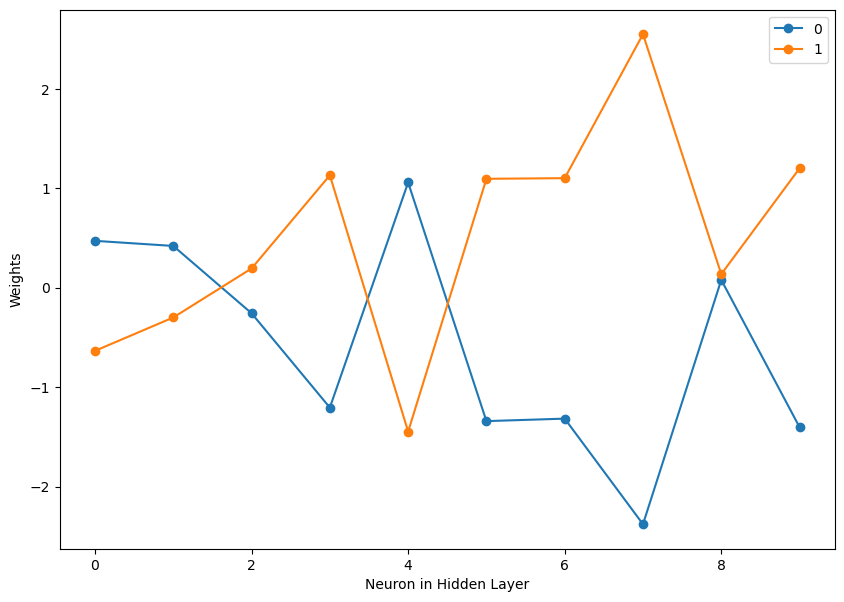

In [13]:
# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7))
for i in range(model[2].weight.size()[0]):
    #if i == 1:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label = i)
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

Text(0, 0.5, 'Weights')

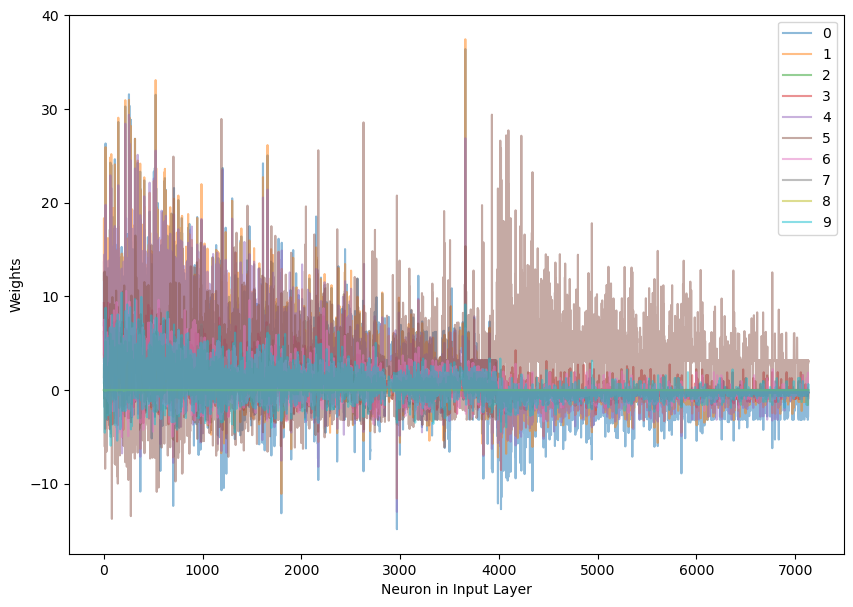

In [14]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
plt.figure(figsize = (10, 7))
for i in range(model[0].weight.size()[0]):
    #if i == 1:
        weights = model[0].weight[i].data.numpy()
        plt.plot(weights, alpha = 0.5, label = i)
plt.legend()
plt.xlabel('Neuron in Input Layer')
plt.ylabel('Weights')

In [15]:
# 将第二层的各个神经元与输入层的链接权重，挑出来最大的权重和最小的权重，并考察每一个权重所对应的单词是什么，把单词打印出来
# model[0]是取出第一层的神经元

for i in range(len(model[0].weight)):
    print('\n')
    print('第{}个神经元'.format(i))
    print('max:')
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
    for i in range(1, 20):
        word = index2word(st[-i][1],diction)
        print(word)
    print('min:')
    for i in range(20):
        word = index2word(st[i][1],diction)
        print(word)




第0个神经元
max:
nbsp
耐心
YY
光临
划算
完全一致
棒棒
热情
不贵
上档次
惊喜
相当
超值
quot
掌柜的
款
必须
生意兴隆
棒
min:
差评
垃圾
差劲
差
很差
发错
不好
最差
烂
不行
申请
醉
说话
好差
不如
地摊货
明明
月
单大
蓝色


第1个神经元
max:
nbsp
YY
耐心
划算
光临
棒棒
完全一致
热情
上档次
不贵
掌柜的
相当
超值
低
惊喜
生意兴隆
大众化
努力
老朋友
min:
差评
垃圾
差劲
很差
差
说话
不如
不值
一股
不好
最差
蓝色
找
不行
抹布
难看
醉
严重
申请
事


第2个神经元
max:
次鞋
春光明媚
突然
假话
拿货
领比
瘙痒
第一
接单
无色差
gel
会多
升起
雅观
建议
183
心
漏水
只会
min:
鞋子
的
都
好
价格
也
很
店家
这么
太棒了
后
还
园领
便宜
高
跟
了
是不是
领是
们


第3个神经元
max:
太
这
现在
网上
一个
袖子
一点
别人
咋
到
亲们
都
估计
下单
质感
刚
试穿
时间
开始
min:
失望
合适
不错
力
谢谢
挺快
布料
正好
硬
速度
体验
长袖
骗人
绿色
一次性
色差
还会
好鞋
一
不理


第4个神经元
max:
耐心
划算
nbsp
光临
YY
超值
完全一致
热情
款
相当
信誉
棒
蛮
棒棒
掌柜的
上档次
男朋友
quot
不贵
min:
差评
差劲
醉
差
垃圾
不好
说话
太慢
月
烂
破
一星
好差
太差
买回来
不值
很差
上当
千万
申请


第5个神经元
max:
破
一个月
严重
地摊货
不如
丢
一星
差劲
醉
坏
最差
发错
差差
玩意
很差
差评
找
处理
却
min:
谢谢
完全一致
没得说
物超所值
挺不错
很漂亮
力
实惠
可以
号准
购
一家
不错
礼品
耐心
太好
惊喜
划算
还会来
光顾


第6个神经元
max:
推荐
物超所值
考虑
希望
老板
一下
别人
顾客
那么
老
继续
卖家
棒棒
感谢
依旧
我
鞋子
还来
应该
min:
打开
时尚
可要
色差
做工
这是
五分
尺寸
长
热心
一次性
三个
讲
长袖
不想
不好
很大
太慢
歪
咨询


第7个神经元
max:
耐心
摸
nbsp
合身
外观
起来
上档次
超值
男朋友
没得说
关

#### 2. 寻找判断错误的原因

In [16]:
# 收集到在测试集中判断错误的句子
wrong_sentences = []
targets = []
j = 0
sent_indices = []
for data, target in zip(test_data, test_label):
    predictions = model(torch.tensor(data, dtype = torch.float).view(1,-1))
    pred = torch.max(predictions.data, 1)[1]
    target = torch.tensor(np.array([target]), dtype = torch.long).view_as(pred)
    rights = pred.eq(target)
    indices = np.where(rights.numpy() == 0)[0]
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        sent_indices.append(test_size + j + i)
    j += len(target)

In [17]:
# 逐个查看出错的句子是什么
idx = 1
print(sent_indices)
print(sentences[sent_indices[idx]])
print(targets[idx].numpy())
lst = list(np.where(wrong_sentences[idx]>0)[0])
mm = list(map(lambda x:index2word(x, diction), lst))
print(mm)

[1334, 1337, 1338, 1342, 1345, 1353, 1365, 1384, 1398, 1402, 1410, 1415, 1419, 1430, 1445, 1469, 1475, 1487, 1488, 1494, 1500, 1509, 1526, 1533, 1538, 1539, 1540, 1549, 1555, 1566, 1588, 1589, 1592, 1606, 1627, 1631, 1632, 1663, 1679, 1684, 1687, 1694, 1697, 1700, 1704, 1708, 1710, 1726, 1744, 1752, 1753, 1759, 1762, 1772, 1778, 1784, 1789, 1792, 1796, 1803, 1808, 1855, 1873, 1874, 1895, 1897, 1909, 1912, 1918, 1928, 1954, 1957, 1963, 1968, 1969, 1971, 1987, 1990, 1998, 2021, 2022, 2025, 2033, 2034, 2041, 2071, 2077, 2079, 2094, 2097, 2099, 2124, 2151, 2159, 2161, 2163, 2170, 2172, 2188, 2216, 2227, 2238, 2257, 2264, 2268, 2292, 2318, 2321, 2334, 2343, 2372, 2395, 2406, 2437, 2446, 2447, 2526, 2532, 2545, 2568, 2579, 2588, 2598]
['就', '这样']
1
['就', '这样']


In [18]:
# 观察第一层的权重与输入向量的内积结果，也就是对隐含层神经元的输入，其中最大数值对应的项就是被激活的神经元
# 负值最小的神经元就是被抑制的神经元
model[0].weight.data.numpy().dot(wrong_sentences[idx].reshape(-1, 1))

array([[ 4.65073502e+00],
       [ 6.09032488e+00],
       [-3.54186888e-03],
       [ 4.30997729e+00],
       [ 7.29399824e+00],
       [ 1.73723663e+00],
       [ 3.29351735e+00],
       [ 8.27419162e-02],
       [-7.85074802e-03],
       [ 7.87463188e-02]])

In [19]:
# 显示输入句子的非零项，即对应单词不为空的项，看它们到隐含层指定神经元的权重是多少
model[0].weight[0].data.numpy()[np.where(wrong_sentences[idx]>0)[0]]

array([2.2339523, 7.0675178], dtype=float32)

## 三、RNN模型

我们分别比较了两种RNN模型，一个是普通的RNN模型，另一个是LSTM。

主要目的是了解RNN模型如何实现，以及考察它们在测试数据集上的分类准确度

### 1. 普通RNN模型

In [20]:
# 需要重新数据预处理，主要是要加上标点符号，它对于RNN起到重要作用
# 数据来源文件
good_file = 'good.txt'
bad_file  = 'bad.txt'
# 生成正样例和反样例，以及词典，很有趣的是，词典中的词语竟然比不考虑标点符号的时候少了（要知道标点也是被当作一个单词的），
# 主要原因应该是总的分词出来的数量变少了。当去掉标点符号以后，有很多字的组合被当作了单词处理了。
pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, False)

good.txt 包含 8089 行, 136359 个词.
bad.txt 包含 5076 行, 75600 个词.
字典大小：7029


In [21]:
# 重新准备数据，输入给RNN
# 与词袋模型不同的是。每一个句子在词袋模型中都被表示为了固定长度的向量，其中长度为字典的尺寸
# 在RNN中，每一个句子就是被单独当成词语的序列来处理的，因此序列的长度是与句子等长的

dataset = []
labels = []
sentences = []

# 正例集合
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            # 注意将每个词编码
            new_sentence.append(word2index(l, diction))
    #每一个句子都是一个不等长的整数序列
    dataset.append(new_sentence)
    labels.append(0)
    sentences.append(sentence)

# 反例集合
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(new_sentence)
    labels.append(1)
    sentences.append(sentence)

# 重新对数据洗牌，构造数据集合
indices = np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

test_size = len(dataset) // 10

# 训练集
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

# 校验集
valid_data = dataset[: test_size]
valid_label = labels[: test_size]

# 测试集
test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]


In [22]:
# 一个手动实现的RNN模型

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # 一个embedding层
        self.embed = nn.Embedding(input_size, hidden_size)
        # 隐含层内部的相互链接
        self.i2h = nn.Linear(2 * hidden_size, hidden_size)
        # 隐含层到输出层的链接
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        
        # 先进行embedding层的计算，它可以把一个数或者数列，映射成一个向量或一组向量
        # input尺寸：seq_length, 1
        x = self.embed(input)
        # x尺寸：hidden_size
        
        # 将输入和隐含层的输出（hidden）耦合在一起构成了后续的输入
        combined = torch.cat((x, hidden), 1)
        # combined尺寸：2*hidden_size
        #
        # 从输入到隐含层的计算
        hidden = self.i2h(combined)
        # combined尺寸：hidden_size
        
        # 从隐含层到输出层的运算
        output = self.i2o(hidden)
        # output尺寸：output_size
        
        # softmax函数
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # 对隐含单元的初始化
        # 注意尺寸是：batch_size, hidden_size
        return torch.zeros(1, self.hidden_size)



In [23]:
# 开始训练这个RNN，10个隐含层单元
rnn = RNN(len(diction), 10, 2)

# 交叉熵评价函数
cost = torch.nn.NLLLoss()

# Adam优化器
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.001)
records = []

# 学习周期10次
losses = []
for epoch in range(10):
    
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = torch.tensor(x, dtype = torch.long).unsqueeze(1)
        #x尺寸：seq_length（序列的长度）
        y = torch.tensor(np.array([y]), dtype = torch.long)
        #x尺寸：batch_size = 1,1
        optimizer.zero_grad()
        
        #初始化隐含层单元全为0
        hidden = rnn.initHidden()
        # hidden尺寸：batch_size = 1, hidden_size
        
        #手动实现RNN的时间步循环，x的长度就是总的循环时间步，因为要把x中的输入句子全部读取完毕
        for s in range(x.size()[0]):
            output, hidden = rnn(x[s], hidden)
        
        #校验函数
        loss = cost(output, y)
        losses.append(loss.data.numpy())
        loss.backward()
        # 开始优化
        optimizer.step()
        if i % 3000 == 0:
            # 每间隔3000步来一次校验集上面的计算
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, dtype = torch.long).unsqueeze(1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                hidden = rnn.initHidden()
                for s in range(x.size()[0]):
                    output, hidden = rnn(x[s], hidden)
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy())
            # 计算准确度
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

C:\Users\86134\AppData\Local\Temp\ipykernel_14680\2964675231.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


第0轮，训练损失：0.49, 测试损失：0.76, 测试准确率: 0.38
第0轮，训练损失：0.55, 测试损失：0.46, 测试准确率: 0.79
第0轮，训练损失：0.48, 测试损失：0.38, 测试准确率: 0.86
第0轮，训练损失：0.44, 测试损失：0.35, 测试准确率: 0.88
第1轮，训练损失：0.43, 测试损失：0.35, 测试准确率: 0.88
第1轮，训练损失：0.40, 测试损失：0.34, 测试准确率: 0.88
第1轮，训练损失：0.39, 测试损失：0.31, 测试准确率: 0.89
第1轮，训练损失：0.37, 测试损失：0.31, 测试准确率: 0.90
第2轮，训练损失：0.37, 测试损失：0.30, 测试准确率: 0.90
第2轮，训练损失：0.35, 测试损失：0.31, 测试准确率: 0.89
第2轮，训练损失：0.34, 测试损失：0.29, 测试准确率: 0.90
第2轮，训练损失：0.34, 测试损失：0.29, 测试准确率: 0.90
第3轮，训练损失：0.33, 测试损失：0.29, 测试准确率: 0.90
第3轮，训练损失：0.33, 测试损失：0.30, 测试准确率: 0.89
第3轮，训练损失：0.32, 测试损失：0.28, 测试准确率: 0.90
第3轮，训练损失：0.32, 测试损失：0.28, 测试准确率: 0.90
第4轮，训练损失：0.31, 测试损失：0.29, 测试准确率: 0.90
第4轮，训练损失：0.31, 测试损失：0.29, 测试准确率: 0.89
第4轮，训练损失：0.30, 测试损失：0.28, 测试准确率: 0.90
第4轮，训练损失：0.30, 测试损失：0.28, 测试准确率: 0.90
第5轮，训练损失：0.30, 测试损失：0.28, 测试准确率: 0.90
第5轮，训练损失：0.30, 测试损失：0.28, 测试准确率: 0.89
第5轮，训练损失：0.29, 测试损失：0.28, 测试准确率: 0.90
第5轮，训练损失：0.29, 测试损失：0.28, 测试准确率: 0.91
第6轮，训练损失：0.29, 测试损失：0.28, 测试准确率: 0.90
第6轮，训练损失：0.28, 测试损失：0.28, 测试准确率: 0.89
第6轮，训练损失：0.2

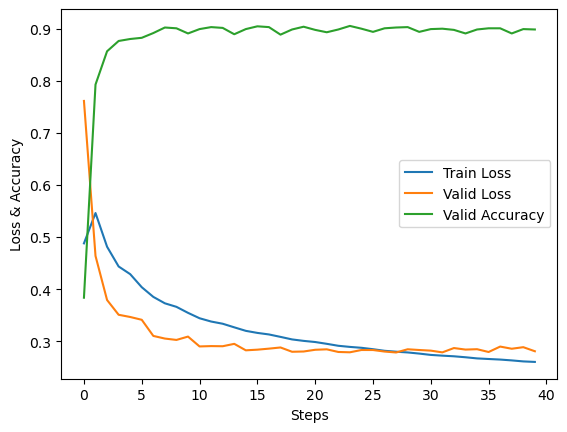

In [24]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [25]:
#在测试集上运行，并计算准确率
vals = [] #记录准确率所用列表
rights = []
#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = torch.LongTensor(x).unsqueeze(1)
    y = torch.LongTensor(np.array([y]))
    hidden = rnn.initHidden()
    for s in range(x.size()[0]):
        output, hidden = rnn(x[s], hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

C:\Users\86134\AppData\Local\Temp\ipykernel_14680\2964675231.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


0.9118541033434651

## LSTM网络

普通RNN的效果比词袋模型稍好一些但仍称不上多好，我们尝试利用改进型的RNN，即LSTM。LSTM与RNN最大的区别就是在于每个神经元中多增加了3个控制门：遗忘门、输入门和输出门. 另外，在每个隐含层神经元中，LSTM多了一个cell的状态，起到了记忆的作用。

这就使得LSTM可以记忆更长时间的Pattern

In [26]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # LSTM的构造如下：一个embedding层，将输入的任意一个单词映射为一个向量
        # 一个LSTM隐含层，共有hidden_size个LSTM神经元
        # 一个全链接层，外接一个softmax输出
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, 2)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, input, hidden=None):
        
        #input尺寸: seq_length
        #词向量嵌入
        embedded = self.embedding(input)
        #embedded尺寸: seq_length, hidden_size
        
        #PyTorch设计的LSTM层有一个特别别扭的地方是，输入张量的第一个维度需要是时间步，
        #第二个维度才是batch_size，所以需要对embedded变形
        embedded = embedded.view(input.data.size()[0], 1, self.hidden_size)
        #embedded尺寸: seq_length, batch_size = 1, hidden_size
    
        #调用PyTorch自带的LSTM层函数，注意有两个输入，一个是输入层的输入，另一个是隐含层自身的输入
        # 输出output是所有步的隐含神经元的输出结果，hidden是隐含层在最后一个时间步的状态。
        # 注意hidden是一个tuple，包含了最后时间步的隐含层神经元的输出，以及每一个隐含层神经元的cell的状态
        
        output, hidden = self.lstm(embedded, hidden)
        #output尺寸: seq_length, batch_size = 1, hidden_size
        #hidden尺寸: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #我们要把最后一个时间步的隐含神经元输出结果拿出来，送给全连接层
        output = output[-1,...]
        #output尺寸: batch_size = 1, hidden_size

        #全链接层
        out = self.fc(output)
        #out尺寸: batch_size = 1, output_size
        # softmax
        out = self.logsoftmax(out)
        return out

    def initHidden(self):
        # 对隐单元的初始化
        
        # 对隐单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        # 对隐单元内部的状态cell的初始化，全0
        cell = torch.zeros(self.n_layers, 1, self.hidden_size)
        return (hidden, cell)



In [27]:
# 开始训练LSTM网络

# 构造一个LSTM网络的实例
lstm = LSTMNetwork(len(diction), 10, 2)

#定义损失函数
cost = torch.nn.NLLLoss()

#定义优化器
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)
records = []

# 开始训练，一共5个epoch，否则容易过拟合
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = torch.LongTensor(x).unsqueeze(1)
        #x尺寸：seq_length，序列的长度
        y = torch.LongTensor([y])
        #y尺寸：batch_size = 1, 1
        optimizer.zero_grad()
        
        #初始化LSTM隐含层单元的状态
        hidden = lstm.initHidden()
        #hidden: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #让LSTM开始做运算，注意，不需要手工编写对时间步的循环，而是直接交给PyTorch的LSTM层。
        #它自动会根据数据的维度计算若干时间步
        output = lstm(x, hidden)
        #output尺寸: batch_size = 1, output_size
        
        #损失函数
        loss = cost(output, y)
        losses.append(loss.data.numpy())
        
        #反向传播
        loss.backward()
        optimizer.step()
        
        #每隔3000步，跑一次校验集，并打印结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.LongTensor(x).unsqueeze(1)
                y = torch.LongTensor(np.array([y]))
                hidden = lstm.initHidden()
                output = lstm(x, hidden)
                #计算校验数据集上的分类准确度
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy())
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

C:\Users\86134\AppData\Local\Temp\ipykernel_14680\1905094972.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.logsoftmax(out)


第0轮，训练损失：0.61, 测试损失：0.72, 测试准确率: 0.38
第0轮，训练损失：0.49, 测试损失：0.37, 测试准确率: 0.86
第0轮，训练损失：0.43, 测试损失：0.34, 测试准确率: 0.88
第0轮，训练损失：0.40, 测试损失：0.31, 测试准确率: 0.89
第1轮，训练损失：0.39, 测试损失：0.31, 测试准确率: 0.90
第1轮，训练损失：0.37, 测试损失：0.29, 测试准确率: 0.90
第1轮，训练损失：0.36, 测试损失：0.30, 测试准确率: 0.90
第1轮，训练损失：0.35, 测试损失：0.29, 测试准确率: 0.90
第2轮，训练损失：0.34, 测试损失：0.29, 测试准确率: 0.91
第2轮，训练损失：0.33, 测试损失：0.27, 测试准确率: 0.91
第2轮，训练损失：0.33, 测试损失：0.28, 测试准确率: 0.91
第2轮，训练损失：0.32, 测试损失：0.27, 测试准确率: 0.91
第3轮，训练损失：0.32, 测试损失：0.27, 测试准确率: 0.91
第3轮，训练损失：0.31, 测试损失：0.27, 测试准确率: 0.91
第3轮，训练损失：0.31, 测试损失：0.27, 测试准确率: 0.91
第3轮，训练损失：0.30, 测试损失：0.26, 测试准确率: 0.91
第4轮，训练损失：0.30, 测试损失：0.27, 测试准确率: 0.91
第4轮，训练损失：0.29, 测试损失：0.27, 测试准确率: 0.91
第4轮，训练损失：0.29, 测试损失：0.27, 测试准确率: 0.90
第4轮，训练损失：0.29, 测试损失：0.27, 测试准确率: 0.91
第5轮，训练损失：0.28, 测试损失：0.27, 测试准确率: 0.91
第5轮，训练损失：0.28, 测试损失：0.27, 测试准确率: 0.91
第5轮，训练损失：0.28, 测试损失：0.29, 测试准确率: 0.90
第5轮，训练损失：0.27, 测试损失：0.26, 测试准确率: 0.91
第6轮，训练损失：0.27, 测试损失：0.27, 测试准确率: 0.91
第6轮，训练损失：0.27, 测试损失：0.27, 测试准确率: 0.91
第6轮，训练损失：0.2

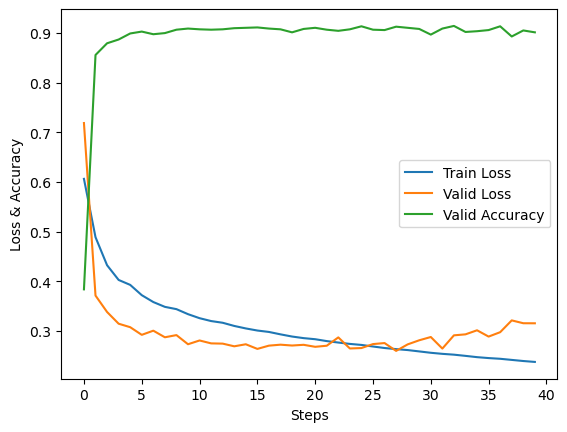

In [28]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [29]:
#在测试集上计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = torch.LongTensor(x).unsqueeze(1)
    y = torch.LongTensor(np.array([y]))
    hidden = lstm.initHidden()
    output = lstm(x, hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

C:\Users\86134\AppData\Local\Temp\ipykernel_14680\1905094972.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.logsoftmax(out)


0.9080547112462006